# HJB Optimal Pairs Trading Strategy
This notebook computes and visualizes the optimal trading thresholds $(x_0, x_1, x_2)$ for a pairs trading model based on the Ornstein-Uhlenbeck process and the HJB equation.
$$
d Z_t=a\left(b-Z_t\right) d t+\sigma d W_t, Z_0=x
$$

### Implementation notes

We use the identity (Parabolic-cylinder representation)
$$
\int_0^{\infty} t^{\nu-1} e^{-\frac{1}{2} x^2-\mu t} d t= \Gamma(\nu) e^{\mu^2/4} D_{-\nu}\left(\mu\right), \quad \operatorname{Re} (\nu)>0
$$
where $D_\alpha$ is the parabolic cylinder function. Let 
$$
\nu=\frac{\rho}{a}, \quad \kappa=\frac{\sqrt{2 a}}{\sigma}, \quad \mu(x)=\kappa(b-x) .
$$
and define (as in `An Optimal Pairs-Trading Rule`)
$$
\eta(t)=t^{\nu-1} e^{-t^2 / 2}, \quad \phi_1(x)=\int_0^{\infty} \eta(t) e^{-\kappa(b-x) t} d t, \quad \phi_2(x)=\int_0^{\infty} \eta(t) e^{\kappa(b-x) t} d t
$$

Then we obtain
$$
\begin{cases}
\phi_1(x) = \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-\nu}\left(\mu(x)\right), \\
\phi_2(x) = \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-\nu}\left(-\mu(x)\right).
\end{cases}
$$

Differentiating under the integral sign wrt $x$ gives
$$
\begin{cases}
\phi_1'(x)=\kappa  \int_0^{\infty}  t^{\nu} e^{-t^2 / 2} e^{-\kappa(b-x) t} d t =  \kappa \nu \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-(\nu+1)}\left(\mu(x)\right), \\
\phi_2'(x)=-\kappa \int_0^{\infty} t^{\nu}  e^{-t^2 / 2}e^{\kappa(b-x) t} d t =  - \kappa \nu \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-(\nu+1)}\left(-\mu(x)\right).
\end{cases}
$$

These identities are used to determine the threshold by solving the non-linear system,
$$
\begin{cases}
\phi_1(M) P_{1, \uparrow}\left(x_0\right)+\phi_2(M) P_{1, \downarrow}\left(x_0\right)=M-K \\
P_{1, \uparrow}\left(x_1\right)=P_{2, \uparrow}\left(x_2\right) \\
P_{1, \downarrow}\left(x_1\right)=P_{2, \downarrow}\left(x_2\right)
\end{cases}
$$
$$
\begin{array}{ll}
P_{1, \uparrow}(x)=\frac{(x+K) \phi_2^{\prime}(x)-\phi_2(x)}{W(x)}, & P_{1, \downarrow}(x)=\frac{\phi_1(x)-(x+K) \phi_1^{\prime}(x)}{W(x)} \\
P_{2, \uparrow}(x)=\frac{(x-K) \phi_2^{\prime}(x)-\phi_2(x)}{W(x)}, & P_{2, \downarrow}(x)=\frac{\phi_1(x)-(x-K) \phi_1^{\prime}(x)}{W(x)}
\end{array}
$$
which is derived by the boundary condition and smooth pasting for the HJB.

In solving for the thresholds, `map_uvw_to_xs` maps unconstrained optimization variables $u, v, w \in \mathbb{R}$ into bounded regions for numerical stability. We require that 

1. $M < x_1 \leq \frac{a b-\rho K}{\rho+a}$
2. $M<x_0<x_1$
3. $x_2>x_1$ and $x_2 \geq \frac{a b+\rho K}{\rho+a}$

To ensure such inequalities are preserved, `logistic` and `softplus` transformations are applied to ensure that constrained least squares works and converges properly.

In [ ]:
# Constants
import numpy as np
from scipy.special import pbdv
from scipy.optimize import least_squares
from scipy.special import gamma

EPSILON = 1e-6

def compute_threshold(a = 1.0, sigma = 0.56, rho = 0.1, K = 0.001, b = 0, M = -0.2):
    """
    Computes the threshold values for a given set of parameters.

    Args:
        a (float): The speed of mean reversion.
        sigma (float): The volatility of the underlying asset.
        rho (float): The risk-free rate.
        K (float): The strike price of the option.
        b (float): The long-term mean of the underlying asset.
        M (float): The initial value of the underlying asset.

    Returns:
        tuple: A tuple containing the threshold values (x0, x1, x2).
    """
    # Input Validation
    if a <= 0:
        raise ValueError("Mean reversion speed must be positive.")
    if sigma <= 0:
        raise ValueError("Volatility must be positive.")
    if rho <= 0:
        raise ValueError("Risk-free rate must be positive.")

    nu = rho / a
    kappa = np.sqrt(2 * a) / sigma
    GAM = gamma(nu)
    B1 = (a * b - rho * K) / (rho + a)
    B2 = (a * b + rho * K) / (rho + a)

    # Define auxiliary functions
    def mu(x):
        return kappa * (b - x)

    def phi1(x):
        Dv, _ = pbdv(-nu, mu(x))
        return GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def phi2(x):
        Dv, _ = pbdv(-nu, -mu(x))
        return GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def dphi1(x):
        Dv, _ = pbdv(-(nu + 1), mu(x))
        return kappa * nu * GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def dphi2(x):
        Dv, _ = pbdv(-(nu + 1), -mu(x))
        return -kappa * nu * GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def W(x): return phi1(x) * dphi2(x) - dphi1(x) * phi2(x)

    def P1_up(x): return ((x + K) * dphi2(x) - phi2(x)) / W(x)

    def P1_dn(x): return (phi1(x) - (x + K) * dphi1(x)) / W(x)

    def P2_up(x): return ((x - K) * dphi2(x) - phi2(x)) / W(x)

    def P2_dn(x): return (phi1(x) - (x - K) * dphi1(x)) / W(x)

    def logistic(z): return 1.0 / (1.0 + np.exp(-z))

    def softplus(z): return np.log1p(np.exp(z))

    def map_uvw_to_thresholds(u, v, w):
        s1 = logistic(u)
        x1 = M + s1 * (B1 - M)
        s0 = logistic(v)
        x0 = M + s0 * (x1 - M)
        base = max(B2, x1) + EPSILON
        x2 = base + softplus(w)
        return x0, x1, x2

    def residuals_uvw(uvw):
        u, v, w = uvw
        x0, x1, x2 = map_uvw_to_thresholds(u, v, w)
        r1 = phi1(M) * P1_up(x0) + phi2(M) * P1_dn(x0) - (M - K)
        r2 = P1_up(x1) - P2_up(x2)
        r3 = P1_dn(x1) - P2_dn(x2)
        return np.array([r1, r2, r3], dtype=float)

    uvw0 = np.array([0.0, -1.0, 0.0])
    sol = least_squares(residuals_uvw, uvw0, method='trf', ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=20000)

    if not sol.success:
        print("Optimization failed to converge.")
        return None  # Or raise an exception

    u_hat, v_hat, w_hat = sol.x
    x0, x1, x2 = map_uvw_to_thresholds(u_hat, v_hat, w_hat)

    print(f'Parameters: a={a}, sigma={sigma}, rho={rho}, K={K}, b={b}, M={M}')
    print(f'Converged to (x_0, x_1, x_2) = ({x0:.3f}, {x1:.3f}, {x2:.3f})')

    return x0, x1, x2

In [210]:
a, sigma, rho, K, b, M = 1, 0.56, 0.1, 0.001, 0, -0.2

x0, x1, x2 = compute_threshold()

Parameters: a=1.0, sigma=0.56, rho=0.1, K=0.001, b=0, M=-0.2
Converged with (x_0, x_1, x_2) = (-0.141, -0.076, 0.076)


In [235]:
# Simulate process

# n_steps = 252 * 1 # Corresponds to n years
n_steps = 252

# Each time step is a single dayr
dt = 1/252 
N_PATH = 4

r = np.zeros((N_PATH, n_steps), dtype=np.float64)
r[:, 0] = b  # start at long-run mean

factor = np.exp(-a*dt)
for col in range(1, n_steps):
    r[:, col] += factor*r[:, col-1] + np.random.normal(loc = b * (1-factor),
                                                       scale = sigma * np.sqrt(0.5 / a * (1 - np.exp(-2 * a*dt))),
                                                       size = N_PATH)

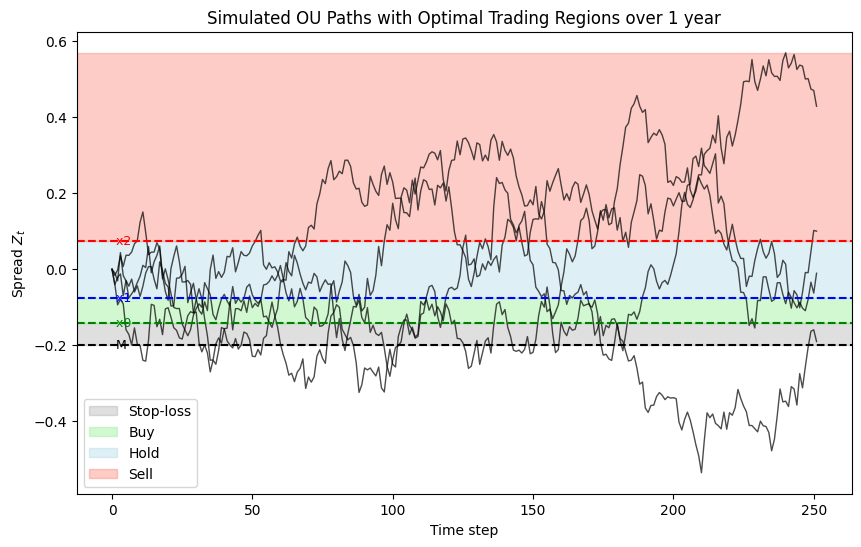

In [238]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(10,6))
for i in range(N_PATH):
    ax.plot(r[i], lw=1, alpha=0.7, color='black')

# Draw regions
ax.axhspan(M, x0, color='gray', alpha=0.25, label='Stop-loss')
ax.axhspan(x0, x1, color='lightgreen', alpha=0.4, label='Buy')
ax.axhspan(x1, x2, color='lightblue', alpha=0.4, label='Hold')
ax.axhspan(x2, max(r.max(), x2+0.05), color='salmon', alpha=0.4, label='Sell')

# Boundaries
for val, col, label in [(M, 'black', 'M'), (x0, 'green', 'x0'), (x1, 'blue', 'x1'), (x2, 'red', 'x2')]:
    ax.axhline(val, color=col, linestyle='--')
    ax.text(0, val, f' {label}', va='center', color=col, fontsize=9)

ax.set_xlabel('Time step')
ax.set_ylabel('Spread $Z_t$')
ax.set_title('Simulated OU Paths with Optimal Trading Regions over 1 year')
ax.legend()
plt.show()


## Monte Carlo Simulation Validation
We simulate multiple Ornstein–Uhlenbeck paths and execute the trading rule defined by $(x_0, x_1, x_2, M)$ to estimate expected profit and variability.

In [ ]:

# --- Monte Carlo Simulation for Strategy Performance ---

def simulate_strategy(a, b, sigma, rho, K, M, x0, x1, x2,
                      n_paths=10000, n_steps=252*5, dt=1/252, seed=42):
    np.random.seed(seed)
    profits = []
    
    for _ in range(n_paths):
        Z = np.zeros(n_steps)
        Z[0] = 0  # start at equilibrium
        holding = False
        buy_price = 0.0
        total_profit = 0.0
        
        for t in range(1, n_steps):
            Z[t] = Z[t-1] + a*(b - Z[t-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
            
            if not holding and x0 < Z[t] < x1:
                holding = True
                buy_price = Z[t]
                total_profit -= K  # transaction cost
            
            elif holding:
                if Z[t] > x2:  # sell
                    total_profit += (Z[t] - buy_price) - K
                    holding = False
                elif Z[t] < M:  # stop-loss
                    total_profit += (Z[t] - buy_price) - K
                    holding = False
        
        profits.append(total_profit)
    
    return np.mean(profits), np.std(profits)

mean_profit, std_profit = simulate_strategy(a, b, sigma, rho, K, M, x0, x1, x2)
print(f"Mean profit: {mean_profit:.4f}, Std: {std_profit:.4f}")

Mean profit: 0.0410, Std: 0.5228



## 📘 Comparison: Paper vs Our Implementation

| Concept | In the Paper *(An Optimal Pairs-Trading Rule)* | In Our Notebook |
|----------|-----------------------------------------------|-----------------|
| **State variable** | Spread $Z_t$ follows Ornstein–Uhlenbeck process | Simulated OU process numerically |
| **Control decision** | Buy / Sell / Wait / Stop determined by HJB solution | Implemented via threshold $(M, x_0, x_1, x_2)$ |
| **Mathematical framework** | HJB quasi-variational inequality | Solved using numerical least-squares for boundary equations |
| **Key outputs** | Optimal thresholds $(x_0, x_1, x_2)$ | Computed explicitly in Python |
| **Validation** | Monte Carlo simulation (Section 5 of paper) | Performed with 10,000 simulated OU paths |
| **Visualization** | Conceptual trading regions diagram | Generated trading region chart + OU trajectories |

The notebook is thus a **computational reconstruction** of the theoretical model in the paper,
bridging abstract HJB mathematics and practical algorithmic trading simulation.


Now we want to observe if this strategy actually works.

We will be simulating the 

In [ ]:
a, b, sigma = 1.0, 0.0, 0.56

n_steps = 252 * 5 # Corresponds to n years

# Each time step is a single day
dt = 1/252 
PATHS = 100000

r = np.zeros((PATHS, n_steps), dtype=np.float64)
r[:, 0] = b  # start at long-run mean (or set your own r0)

factor = np.exp(-a*dt)
for col in range(1, n_steps):
    r[:, col] += factor*r[:, col-1] + np.random.normal(loc = b * (1-factor),
                                                       scale = sigma * np.sqrt(0.5 / a * (1 - np.exp(-2 * a*dt))),
                                                       size = PATHS)

### Simple modification to add shorting

In [243]:
from numba import njit, prange
import numpy as np

@njit
def simulate_one_path(path, x0, x1, x2, M, K):
    capital = 0.0
    holding = False
    for z in path:
        # Buy
        if not holding and (x0 < z < x1):
            holding = True
            capital -= z * (1 + K)
        # Sell
        elif holding and (z > x2 or z < M):
            holding = False
            capital += z * (1 - K)
    return capital

@njit(parallel=True)
def simulate_strategy(paths, x0, x1, x2, M, K):
    n_paths = paths.shape[0]
    res = np.empty(n_paths)
    for i in prange(n_paths):  # parallel loop
        res[i] = simulate_one_path(paths[i], x0, x1, x2, M, K)
    return res

res = simulate_strategy(r, x0, x1, x2, M, K)
print(np.mean(res))
print(np.std(res))

0.08284977616536968
0.5150842438342976


In [245]:
rf = 0.00  # risk-free rate
mean_ret = np.mean(res)
std_ret = np.std(res)

sharpe = (mean_ret - rf) / std_ret if std_ret > 0 else np.nan

print(f"Mean return: {mean_ret:.4f}")
print(f"Volatility:  {std_ret:.4f}")
print(f"Sharpe ratio: {sharpe:.3f}")

Mean return: 0.0828
Volatility:  0.5151
Sharpe ratio: 0.161


### Baseline algorithms to compare



In [190]:
import pandas as pd

K_entry = 1.0
K_exit = 0.5


prices = pd.Series(r[0])

L = 60
mu = prices.rolling(L).mean()
sig =  prices.rolling(L).std(ddof=1)
# plt.plot(r[0])

z_score = (prices - mu) / sig

capital = 0
# Positions: short, long, flat
position = 'FLAT'


for i in range(len(prices)):

    # Skip the front rolling window
    if np.isnan(z_score[i]):
        continue

    z_sc = z_score[i]
    price = prices[i]

    if position == 'FLAT':

        if z_sc > K_entry:
            position = 'SHORT'
            capital += price * (1-K)
        elif z_sc < -K_entry:
            position = 'LONG'
            capital -= price * (1+K)
    
    if position == 'SHORT':
        if -K_exit < z_sc < K_exit:
            position = 'FLAT'
            # Buy it back
            capital -= price * (1+K)
    
    if position == 'LONG':
        if -K_exit < z_sc < K_exit:
            position = 'FLAT'
            # sell it back
            capital += price * (1+K)
    

print(capital)



0.2506663904884836


Final capital: 0.1706


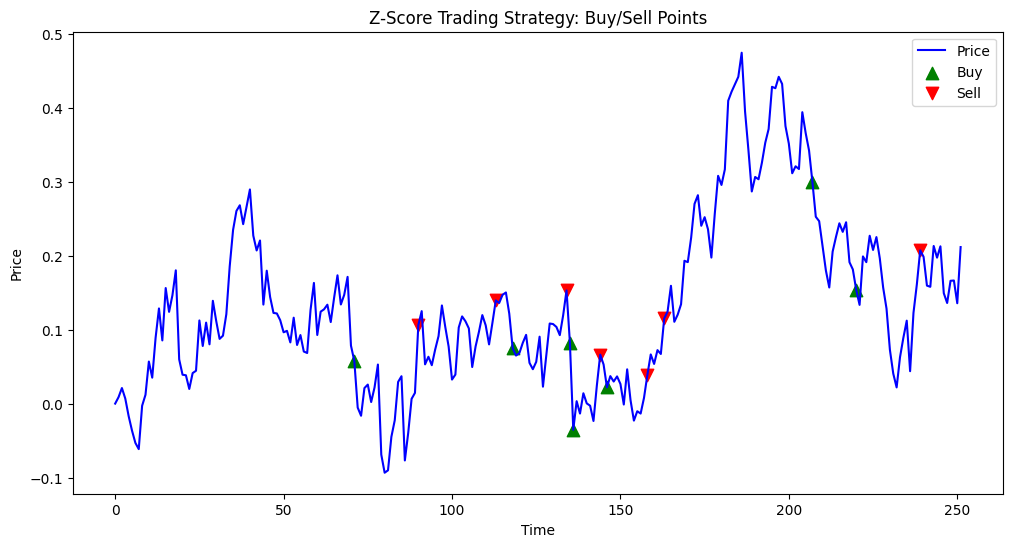

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
K_entry = 1.0
K_exit = 0.5
K = 0.001  # transaction cost

# Example data (replace r[0] with your real data)
prices = pd.Series(r[2])

# --- Compute rolling z-score ---
L = 60
mu = prices.rolling(L).mean()
sig = prices.rolling(L).std(ddof=1)
z_score = (prices - mu) / sig

# --- Trading simulation ---
capital = 0.0
position = 'FLAT'
buy_points = []
sell_points = []

for i in range(len(prices)):
    if np.isnan(z_score[i]):
        continue

    z_sc = z_score[i]
    price = prices[i]

    # Entry
    if position == 'FLAT':
        if z_sc > K_entry:
            position = 'SHORT'
            capital += price * (1 - K)
            sell_points.append((i, price))  # mark sell
        elif z_sc < -K_entry:
            position = 'LONG'
            capital -= price * (1 + K)
            buy_points.append((i, price))  # mark buy

    # Exit
    elif position == 'SHORT':
        if -K_exit < z_sc < K_exit:
            position = 'FLAT'
            capital -= price * (1 + K)
            buy_points.append((i, price))  # buy to cover

    elif position == 'LONG':
        if -K_exit < z_sc < K_exit:
            position = 'FLAT'
            capital += price * (1 + K)
            sell_points.append((i, price))  # sell to close

print(f"Final capital: {capital:.4f}")

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(prices.index, prices, label='Price', color='blue')
plt.scatter(*zip(*buy_points), marker='^', color='green', label='Buy', s=80)
plt.scatter(*zip(*sell_points), marker='v', color='red', label='Sell', s=80)
plt.title("Z-Score Trading Strategy: Buy/Sell Points")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


Total Return: 602796641644421120.00%
Sharpe Ratio: 0.04


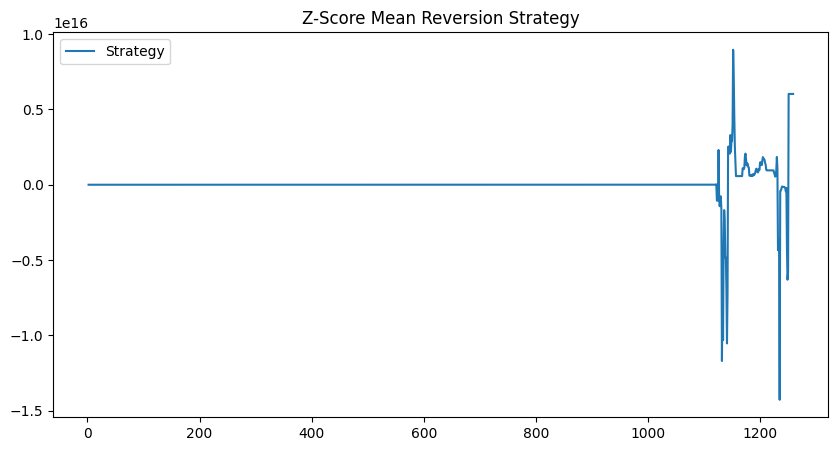

In [184]:
prices = pd.Series(r[5])  # your price series

res = zscore_strategy(prices, L=60, K_entry=1.0, K_exit=0.5, cost=0.001)
print(f"Total Return: {res['total_return']*100:.2f}%")
print(f"Sharpe Ratio: {res['sharpe_ratio']:.2f}")

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(res["equity_curve"], label="Strategy")
plt.title("Z-Score Mean Reversion Strategy")
plt.legend()
plt.show()